In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import load_model

# Load the model
model_path = '/Users/jaeeponde/tai_final_project/fine_tuned_model.h5'
model = load_model(model_path)

# Check if the model is loaded correctly
model.summary()

In [9]:
fake_fake=['/Users/jaeeponde/tai_final_project/rvf_subset_5000/test/fake/041KW4AF4D.jpg', '/Users/jaeeponde/tai_final_project/rvf_subset_5000/test/fake/0DJULYVVJ2.jpg', '/Users/jaeeponde/tai_final_project/rvf_subset_5000/test/fake/0E3OX3LYS1.jpg', '/Users/jaeeponde/tai_final_project/rvf_subset_5000/test/fake/0HOBK2WCQQ.jpg', '/Users/jaeeponde/tai_final_project/rvf_subset_5000/test/fake/0LVHTSBOTQ.jpg']
real_real= ['/Users/jaeeponde/tai_final_project/rvf_subset_5000/test/real/00133.jpg', '/Users/jaeeponde/tai_final_project/rvf_subset_5000/test/real/00167.jpg', '/Users/jaeeponde/tai_final_project/rvf_subset_5000/test/real/00596.jpg', '/Users/jaeeponde/tai_final_project/rvf_subset_5000/test/real/00731.jpg', '/Users/jaeeponde/tai_final_project/rvf_subset_5000/test/real/01044.jpg']

fake_real= ['/Users/jaeeponde/tai_final_project/rvf_subset_5000/test/fake/025AJ3S2VH.jpg', '/Users/jaeeponde/tai_final_project/rvf_subset_5000/test/fake/04U7OSKA3V.jpg', '/Users/jaeeponde/tai_final_project/rvf_subset_5000/test/fake/09LEMMF8O4.jpg', '/Users/jaeeponde/tai_final_project/rvf_subset_5000/test/fake/0KG3PEH9ZI.jpg', '/Users/jaeeponde/tai_final_project/rvf_subset_5000/test/fake/0WSG8DWQ2G.jpg']
real_fake= ['/Users/jaeeponde/tai_final_project/rvf_subset_5000/test/real/02882.jpg', '/Users/jaeeponde/tai_final_project/rvf_subset_5000/test/real/12405.jpg', '/Users/jaeeponde/tai_final_project/rvf_subset_5000/test/real/27462.jpg', '/Users/jaeeponde/tai_final_project/rvf_subset_5000/test/real/30119.jpg', '/Users/jaeeponde/tai_final_project/rvf_subset_5000/test/real/32843.jpg']

In [2]:

# Step 6: Set up data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_generator = train_datagen.flow_from_directory(
    '/Users/jaeeponde/tai_final_project/rvf_subset_5000/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1000 images belonging to 2 classes.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input  # Or use appropriate one for your model

def generate_gradcam_heatmap(model, img_array, layer_name, pred_index=None):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap(heatmap, original_img, alpha=0.4, cmap='jet'):
    heatmap_resized = cv2.resize(heatmap, (original_img.size[0], original_img.size[1]))
    colormap = plt.get_cmap(cmap)
    heatmap_rgb = np.uint8(255 * colormap(heatmap_resized)[..., :3])
    original_array = np.array(original_img)
    superimposed_img = cv2.addWeighted(original_array, 1 - alpha, heatmap_rgb, alpha, 0)
    return superimposed_img

def gradcam_multi_layer(model, image_paths, layer_names):
    for img_path in image_paths:
        # --- Load and preprocess image ---
        original_img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(original_img)
        img_array = np.expand_dims(img_array, axis=0)
        preprocessed_img = train_datagen.standardize(img_array)

        # --- Prediction ---
        prediction = model.predict(preprocessed_img)
        pred_index = np.argmax(prediction)
        predicted_label = "real" if pred_index == 1 else "fake"

        # --- Actual label (from path) ---
        actual_label = img_path.split("/")[-2]

        # --- Plot results ---
        plt.figure(figsize=(4 * (len(layer_names) + 1), 4))
        plt.subplot(1, len(layer_names) + 1, 1)
        plt.imshow(original_img)
        plt.axis('off')
        plt.title("Original")

        for i, layer_name in enumerate(layer_names):
            heatmap = generate_gradcam_heatmap(model, preprocessed_img, layer_name, pred_index)
            superimposed_img = overlay_heatmap(heatmap, original_img)
            plt.subplot(1, len(layer_names) + 1, i + 2)
            plt.imshow(superimposed_img)
            plt.axis('off')
            plt.title(f"{layer_name}")

        # Title showing actual vs predicted
        plt.suptitle(f"{img_path.split('/')[-1]}\nActual: {actual_label} | Predicted: {predicted_label}", fontsize=14)
        plt.tight_layout()
        plt.show()


In [ ]:
# 1. Load model
from tensorflow.keras.models import load_model


layer_names =[
"mixed3",
"conv2d_1",
"conv2d_52",
"mixed6",
"conv2d_93",
"mixed10"]


# 2. Image paths
image_paths = fake_fake

# 3. Choose layers (must be actual layer names from your model)


# 4. Run Grad-CAM
gradcam_multi_layer(model, image_paths, layer_names)


comparison_images = ['/Users/jaeeponde/tai_final_project/rvf_subset_5000/test/real/02882.jpg']


lime_explain_images(comparison_images, num_samples=10)

In [ ]:
layer_names =[
"mixed3",
"conv2d_1",
"conv2d_52",
"mixed6",
"conv2d_93",
"mixed10"]


# 2. Image paths
image_paths = correct

# 3. Choose layers (must be actual layer names from your model)


# 4. Run Grad-CAM
gradcam_multi_layer(model, image_paths, layer_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


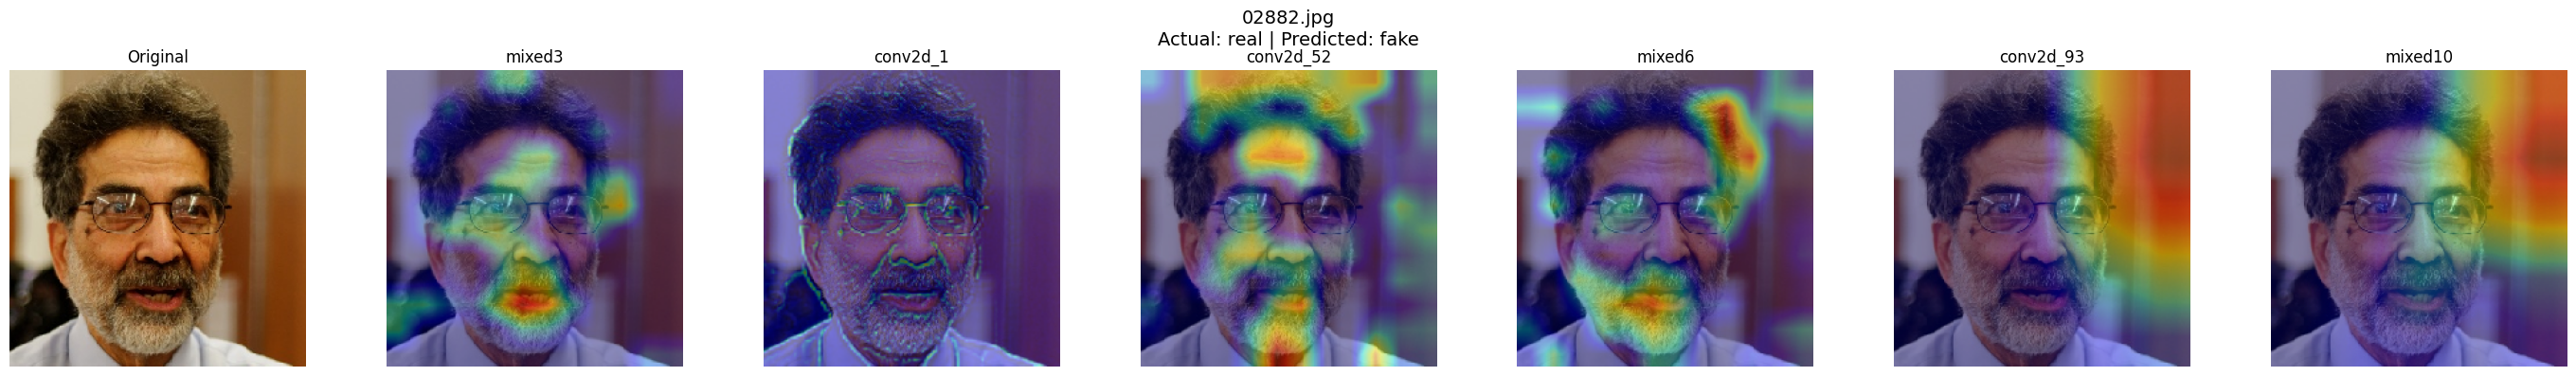

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


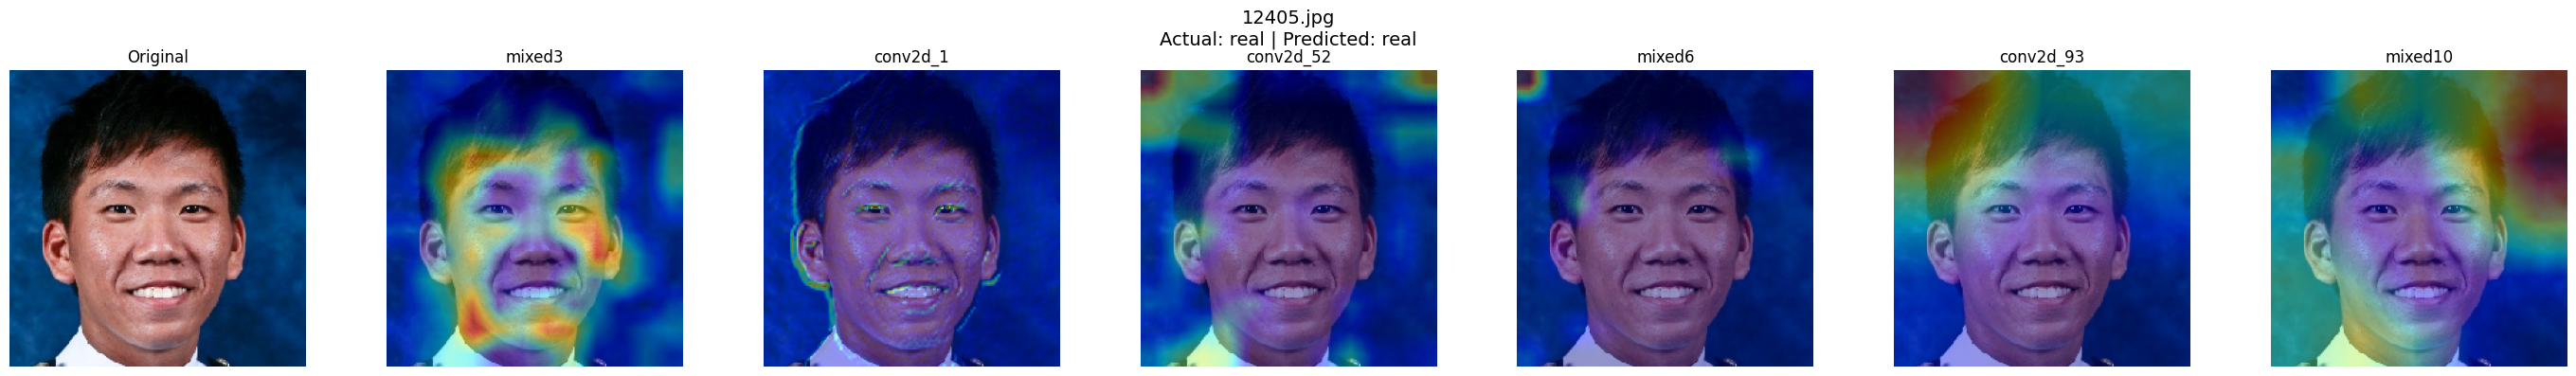

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


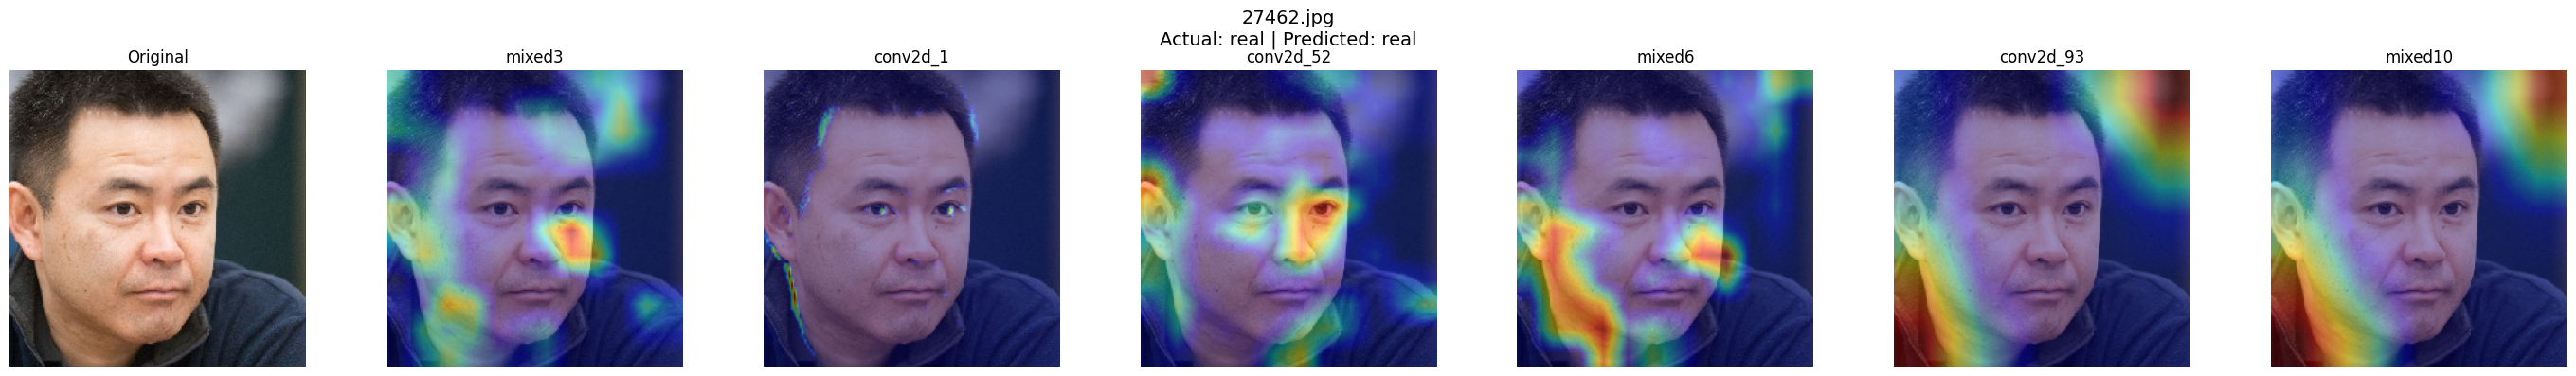

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


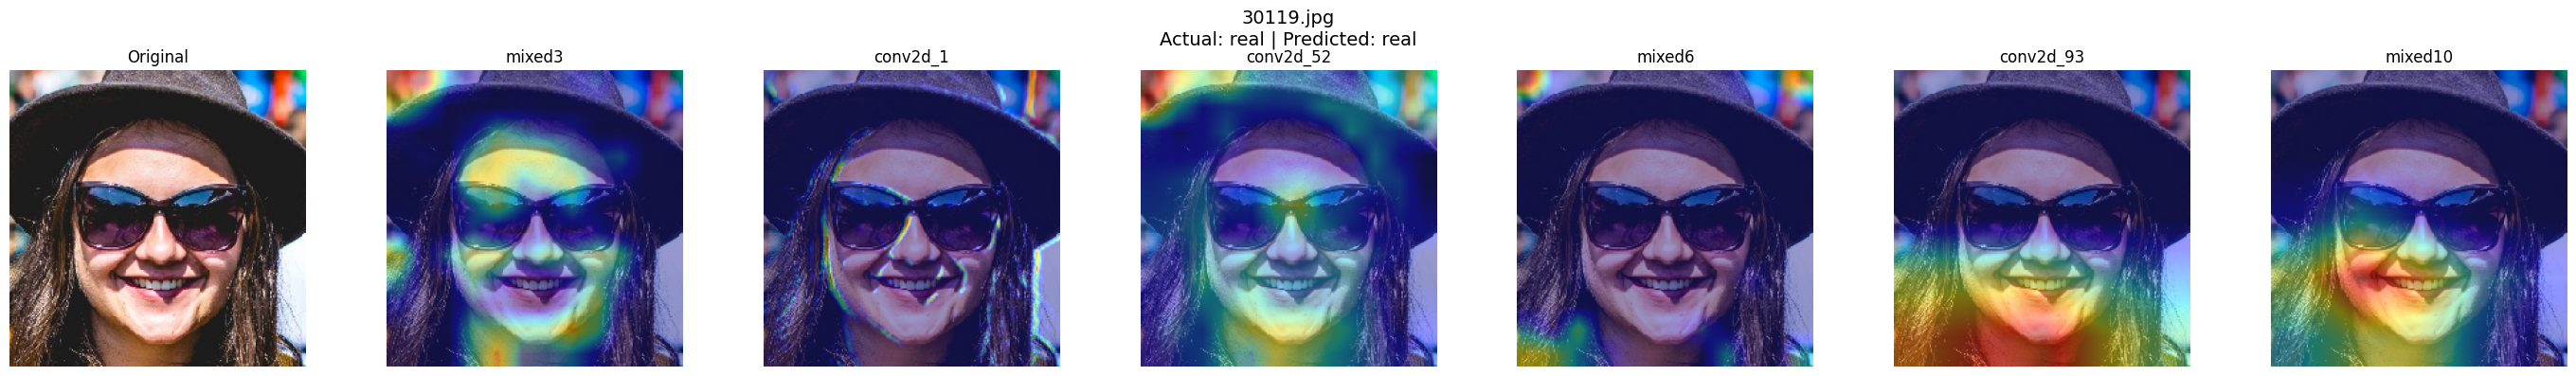

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


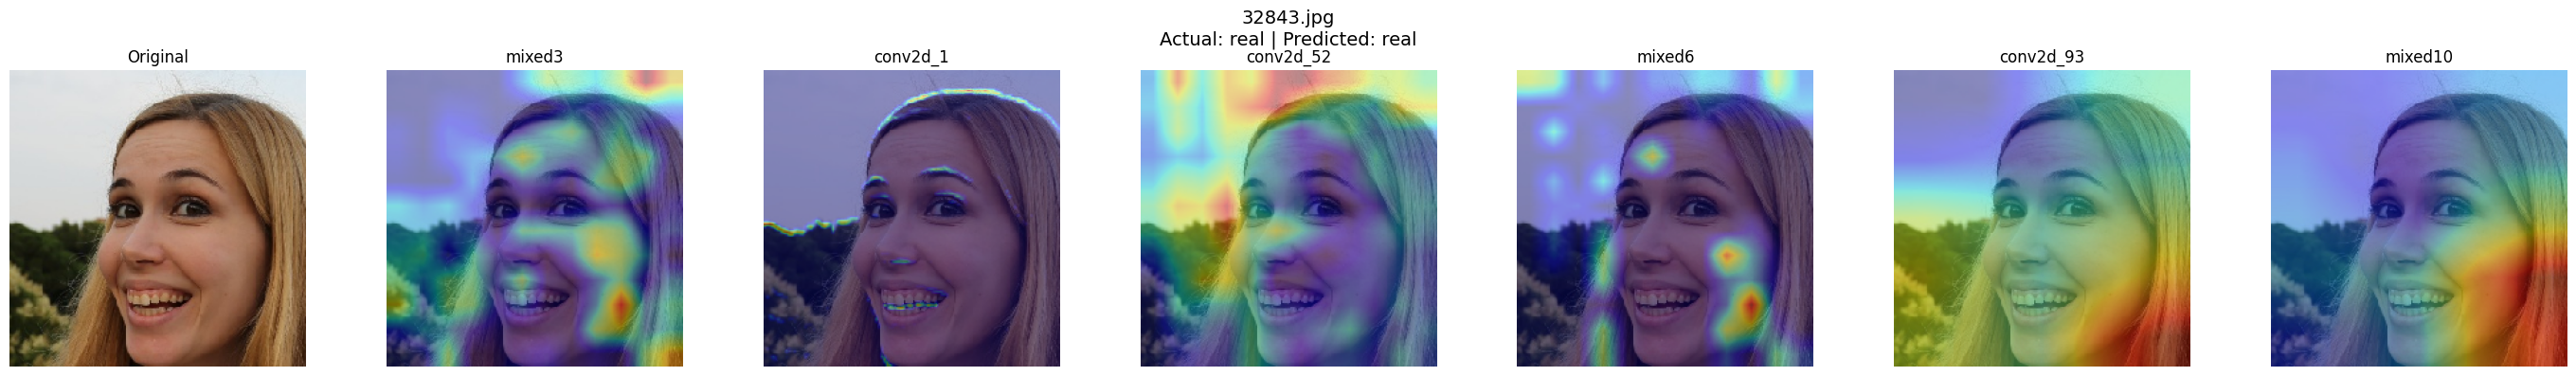

In [10]:
layer_names =[
"mixed3",
"conv2d_1",
"conv2d_52",
"mixed6",
"conv2d_93",
"mixed10"]


# 2. Image paths
image_paths = incorrect_real_images

# 4. Run Grad-CAM
gradcam_multi_layer(model, image_paths, layer_names)

In [11]:
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_incorrect_real_images_as_fake(model, image_folder):
    # Preprocessing setup (same as used in the train_datagen)
    train_datagen = ImageDataGenerator(rescale=1./255)

    # Prepare the file paths
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    incorrect_real_images = []
    real_class_index = 1  # Assuming 'real' class is index 1
    fake_class_index = 0  # Assuming 'fake' class is index 0

    for img_path in image_paths:
        # --- Load and preprocess image ---
        original_img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(original_img)
        img_array = np.expand_dims(img_array, axis=0)
        preprocessed_img = train_datagen.standardize(img_array)  # Use the same preprocessing as the training data

        # --- Predict the class ---
        prediction = model.predict(preprocessed_img)
        pred_class = np.argmax(prediction)

        # --- Check if it is a real image but misclassified as fake ---
        if pred_class == fake_class_index and real_class_index == 1:  # real image incorrectly classified as fake
            incorrect_real_images.append(img_path)
        
        # Stop when we have 4 incorrect real images
        if len(incorrect_real_images) == 4:
            break

    return incorrect_real_images

# Example usage
image_folder = '/Users/jaeeponde/tai_final_project/rvf_subset_5000/test/real'
incorrect_real_images = get_incorrect_real_images_as_fake(model, image_folder)

# Print out the paths of incorrectly classified images
for img in incorrect_real_images:
    print(img)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━

In [12]:
incorrect_real_images

['/Users/jaeeponde/tai_final_project/rvf_subset_5000/test/real/60109.jpg',
 '/Users/jaeeponde/tai_final_project/rvf_subset_5000/test/real/51462.jpg',
 '/Users/jaeeponde/tai_final_project/rvf_subset_5000/test/real/02882.jpg']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


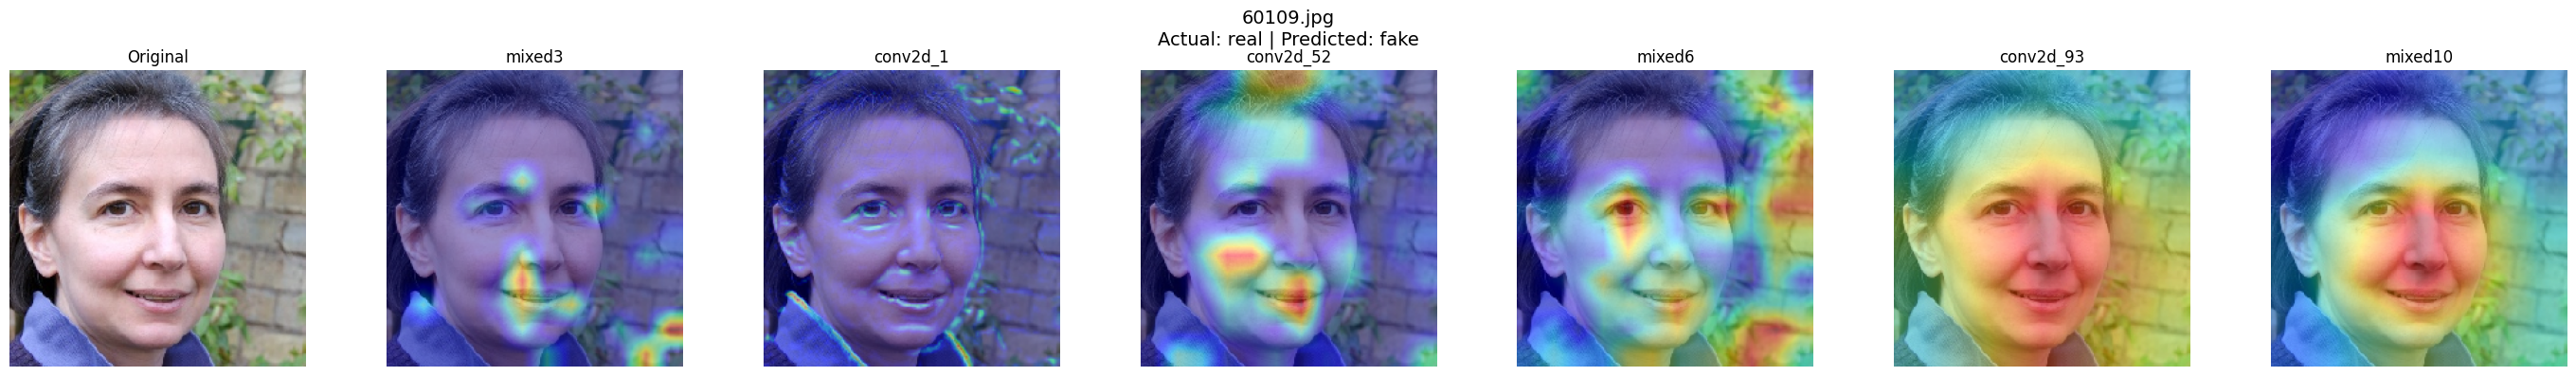

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


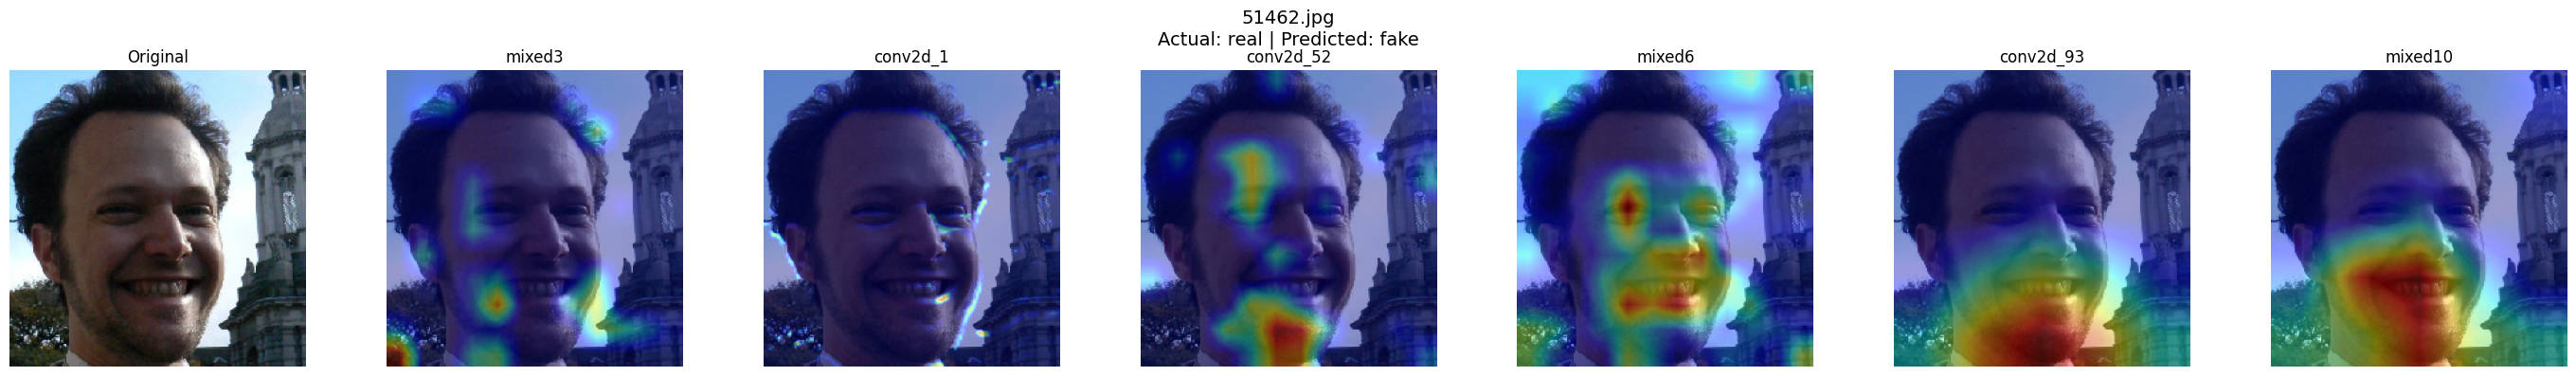

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


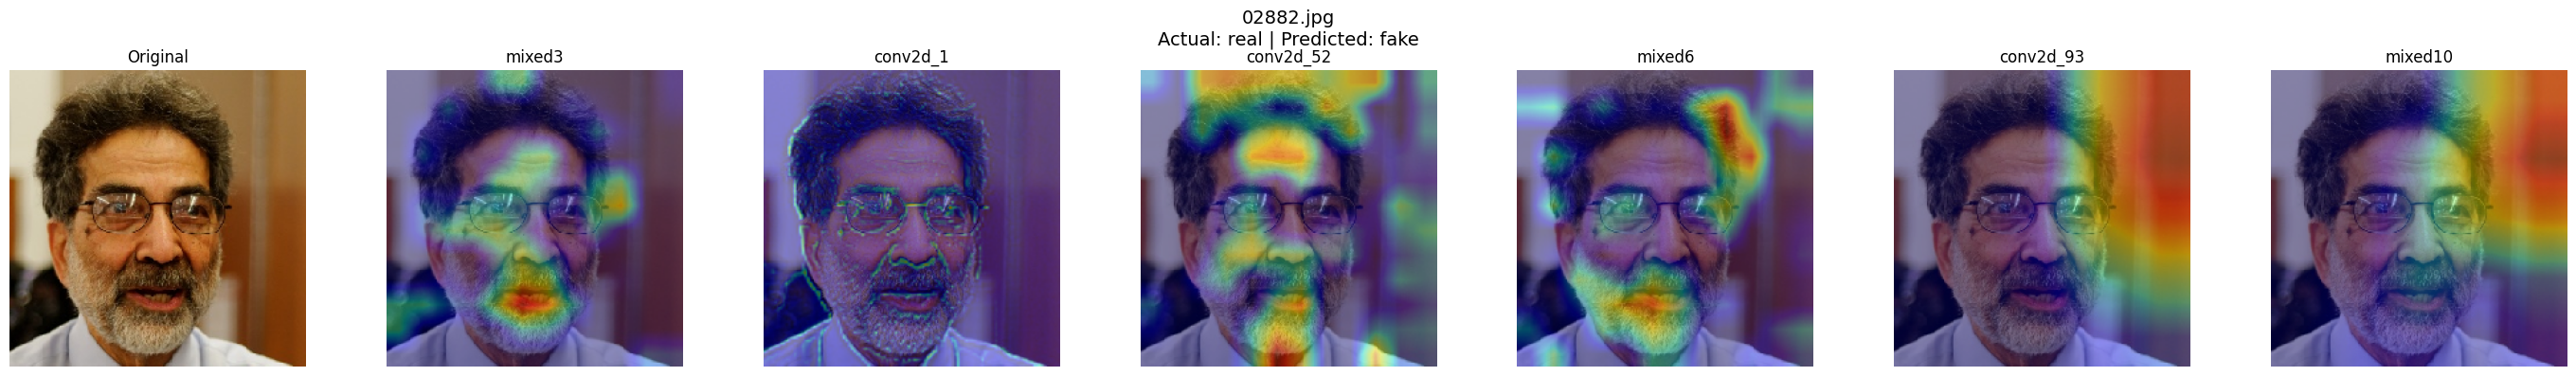

In [13]:
layer_names =[
"mixed3",
"conv2d_1",
"conv2d_52",
"mixed6",
"conv2d_93",
"mixed10"]


# 2. Image paths
image_paths = incorrect_real_images

# 4. Run Grad-CAM
gradcam_multi_layer(model, image_paths, layer_names)

In [ ]:
comparison_images = ['/Users/jaeeponde/tai_final_project/rvf_subset_5000/test/real/60109.jpg',
 '/Users/jaeeponde/tai_final_project/rvf_subset_5000/test/real/51462.jpg',
 '/Users/jaeeponde/tai_final_project/rvf_subset_5000/test/real/02882.jpg']